 47%|███████████████████████████████████▍                                       | 1135/2399 [00:00<00:00, 11267.75it/s]

2399


100%|████████████████████████████████████████████████████████████████████████████| 2399/2399 [00:00<00:00, 9075.98it/s]


Word2Vec(vocab=2399, size=100, alpha=0.03)
[('total permanent disability insurance', 0.9636085033416748), ('the hospital uninsured patient discount act (illinois)', 0.8744980096817017), ('pet insurance', 0.8531007766723633), ('segregated fund', 0.8458371162414551), ('anicom', 0.8453212976455688), ('internal revenue code section 79', 0.8437947034835815), ('individual shared responsibility provision', 0.8400996923446655), ('health advocate', 0.8396177291870117), ('self-funded health care', 0.8363012075424194), ('protectseniors.org', 0.8352371454238892)]


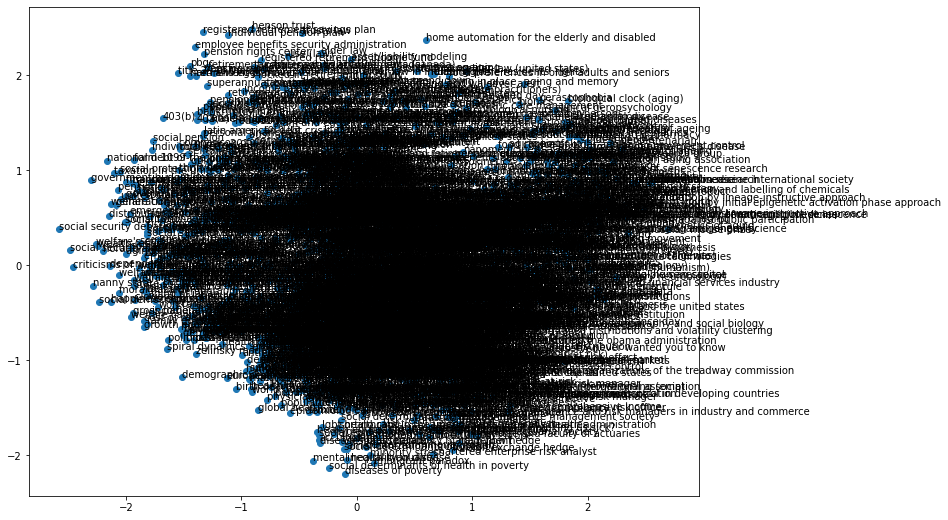

In [6]:
# seealsology DeepWalk
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 数据加载，构造出Graph, 其中sep是tab

df = pd.read_csv('seealsology-data.tsv', sep='\t')
G = nx.from_pandas_edgelist(df,'source', 'target', edge_attr = True, create_using =nx.Graph())
#节点总数
print(len(G)) 

""" 
random walk
超参数， input: 将节点和被遍历的路径的长度作为输入
输出: 返回遍历节点的顺序:
"""
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node        
    return random_walk

# 从图获取所有节点的列表
all_nodes = list(G.nodes())
# 捕获数据集中所有节点的随机游走序列
random_walks = []
for n in tqdm(all_nodes):
    # 设置超参数，每个节点游走5次，每次最长距离为10
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        

# 使用skip-gram，提取模型学习到的权重
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# 训练skip-gram (word2vec)模型
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # 负采样
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)
# 从random_walks中创建词汇表
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)
print(model)
# 输出和critical illness insurance相似的页面
print(model.similar_by_word('critical illness insurance'))


# 在二维空间中绘制所选节点的向量
def plot_nodes(word_list):
	# 每个节点的embedding为100维
    X = model[word_list]
    #print(type(X))
    # 将100维向量减少到2维
    pca = PCA(n_components=2)
    result = pca.fit_transform(X) 
    #print(result)
    # 绘制节点向量
    plt.figure(figsize=(12,9))
    # 创建一个散点图的投影
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()
# 将所有的广本节点embedding进行绘制
plot_nodes(model.wv.vocab)


